# Data preparation

In [1]:
import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [2]:
dataset_folder_path ="../dataset/"

In [3]:
#get the names of all input files ordered by the part number
all_input_files = sorted(glob.glob(dataset_folder_path + "creditcard_part_*.csv"), key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [4]:
df_list = [pd.read_csv(file) for file in all_input_files]
df = pd.concat(df_list, ignore_index=True)

In [5]:
len(df)

284807

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.head().T

,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.columns = df.columns.str.lower()
df.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

In [10]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
v28       float64
amount    float64
class       int64
dtype: object

# Exploratory Data Analysis

In [11]:
df.isnull().sum()

time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
v12       0
v13       0
v14       0
v15       0
v16       0
v17       0
v18       0
v19       0
v20       0
v21       0
v22       0
v23       0
v24       0
v25       0
v26       0
v27       0
v28       0
amount    0
class     0
dtype: int64

In [12]:
#analizing relationship between fraudulent and no fraudulent transactions

In [13]:
df["class"].value_counts(normalize=True)*100

class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

In [14]:
# IMPORTANT: Less than a 1% of records correspond to fraudulent transactions

In [15]:
# Distribution by column

In [16]:
%matplotlib inline

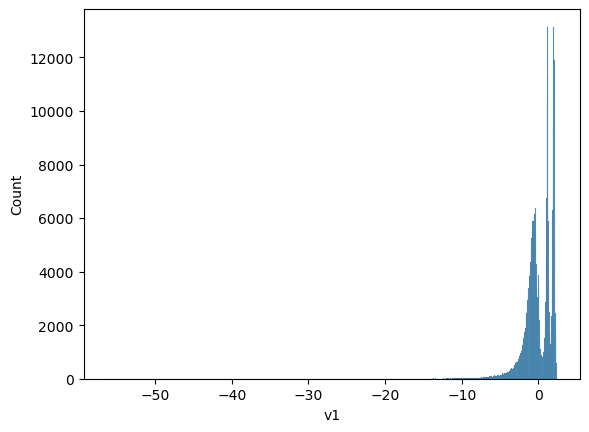

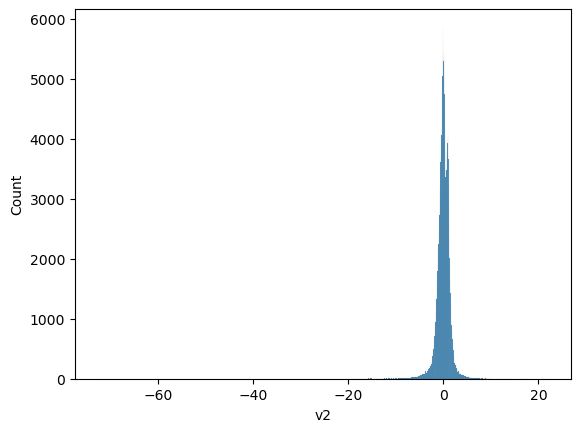

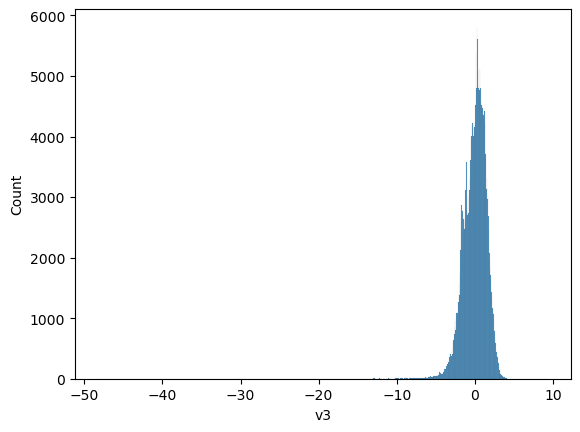

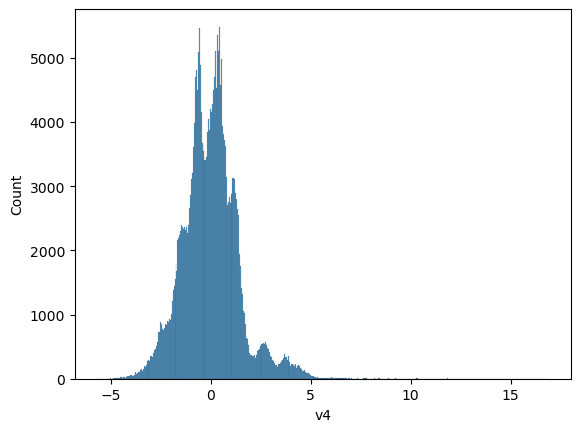

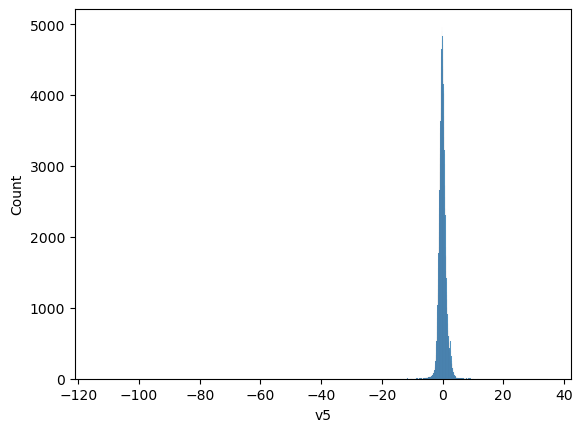

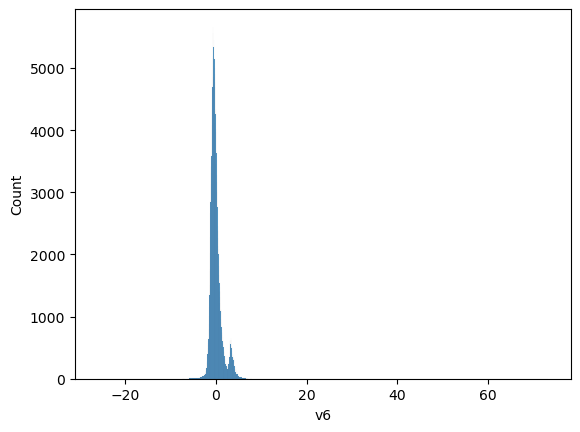

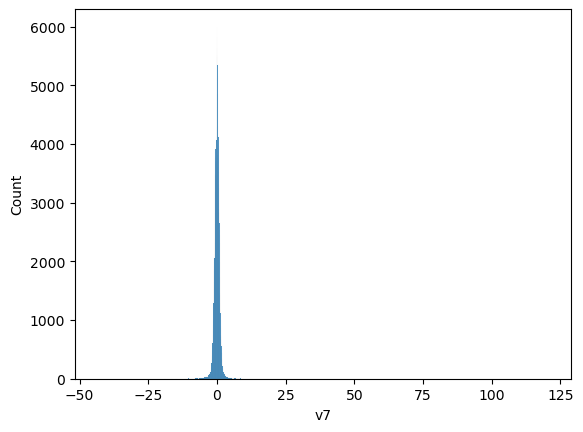

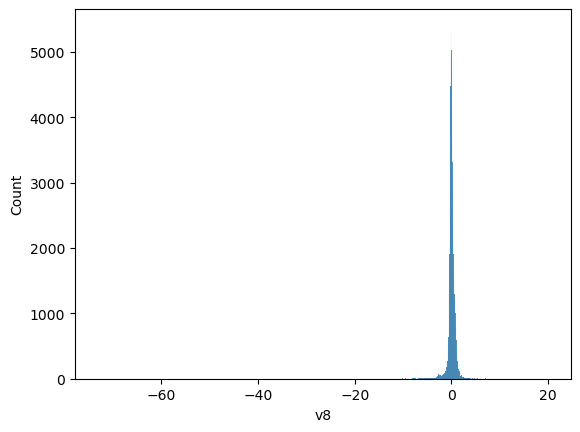

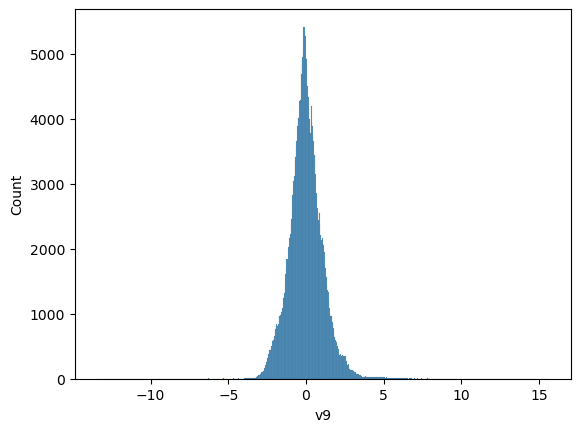

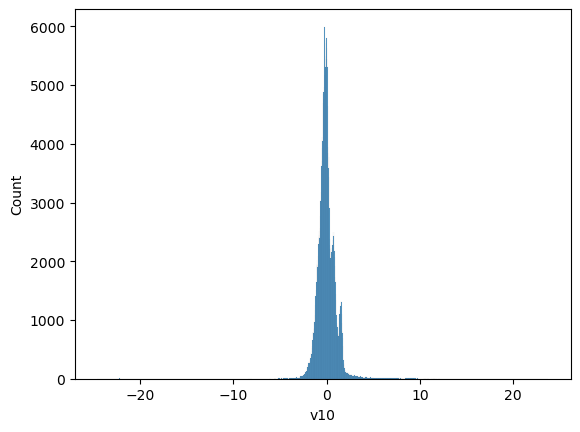

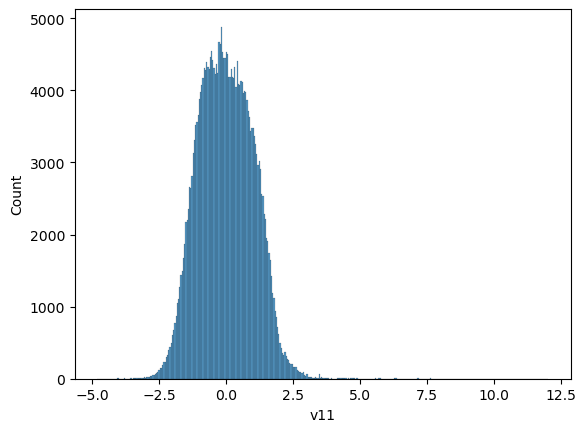

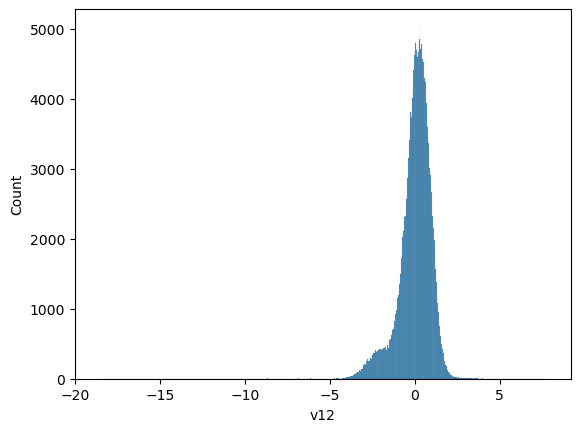

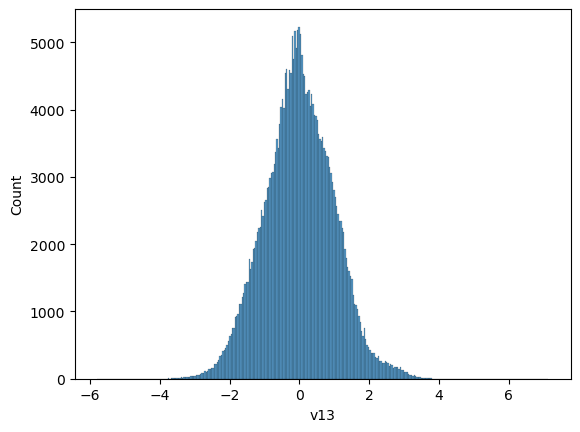

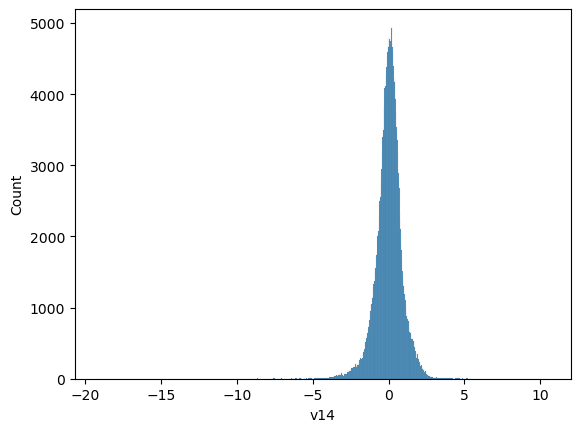

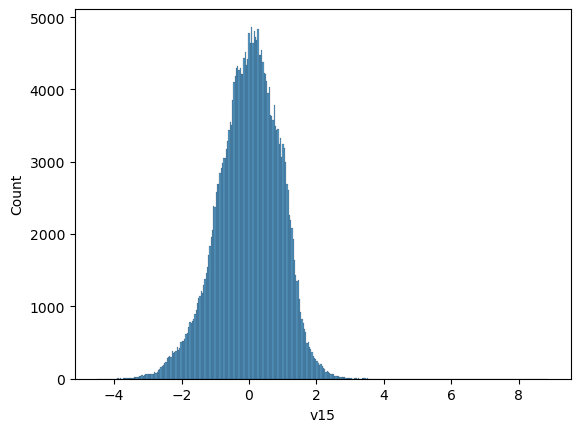

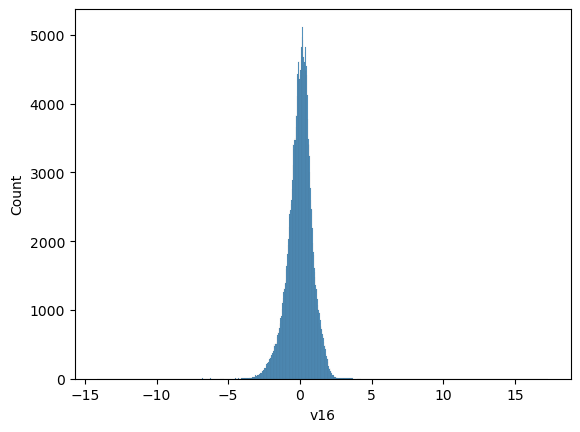

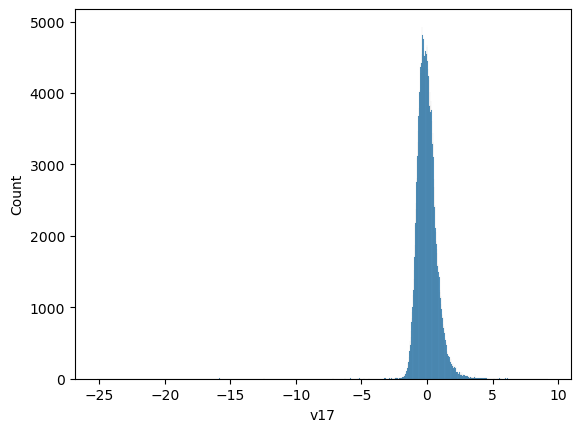

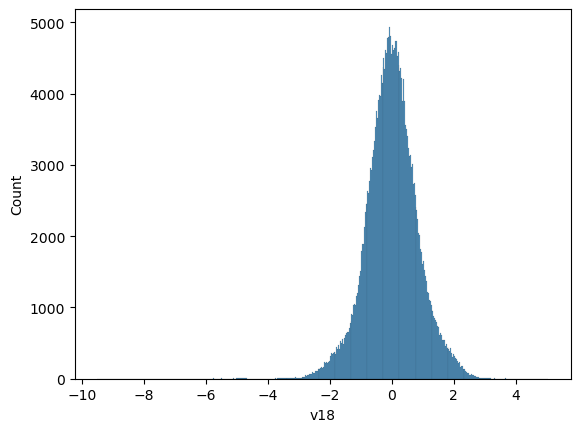

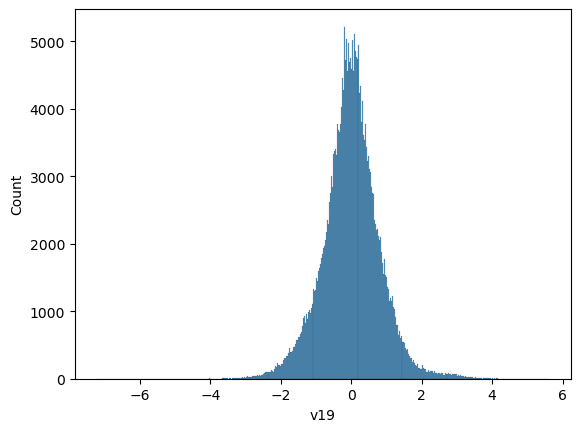

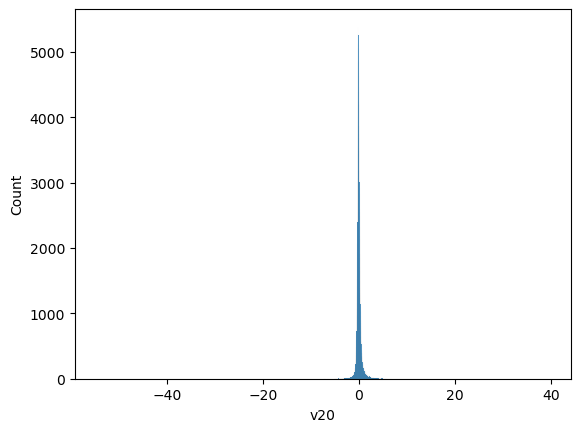

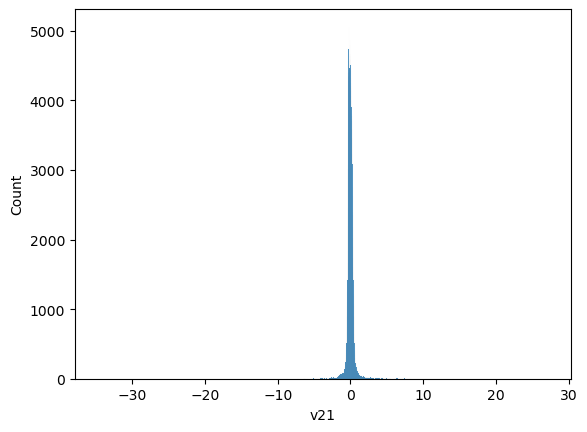

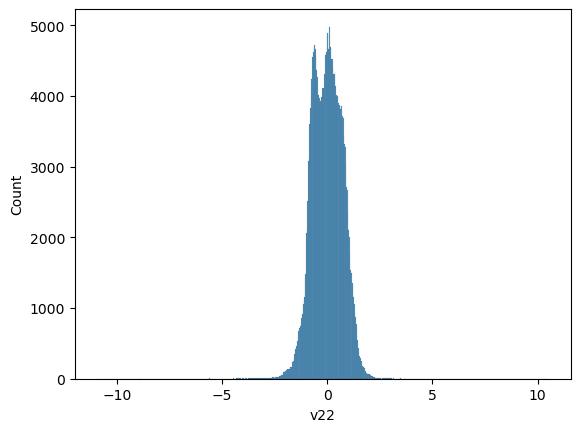

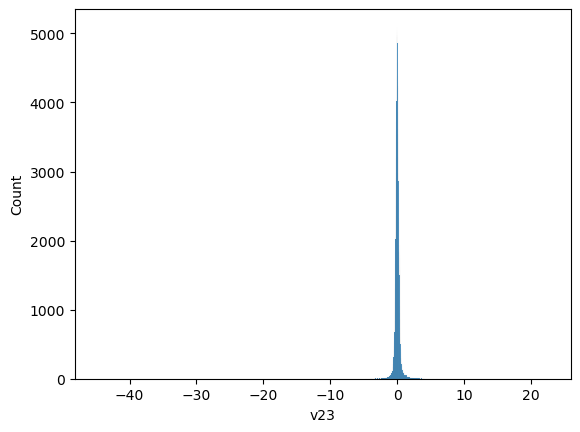

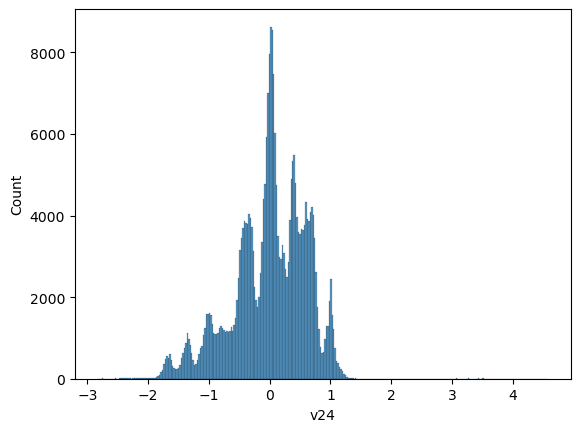

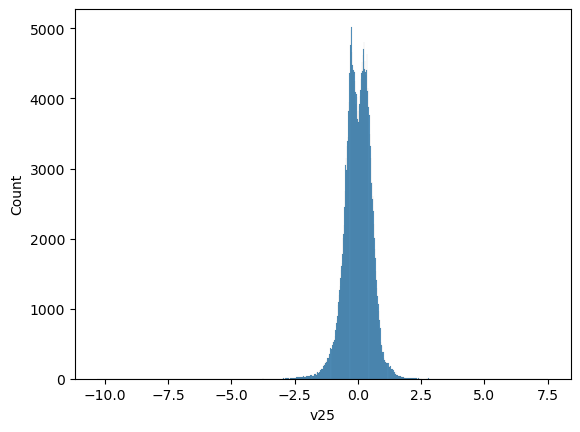

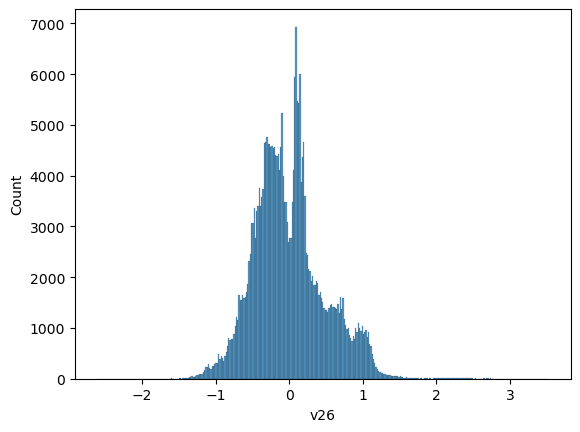

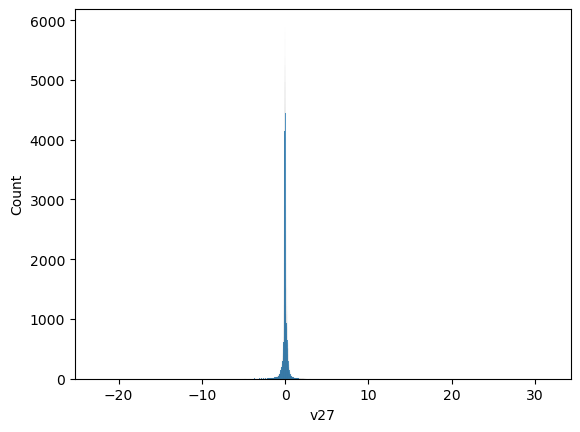

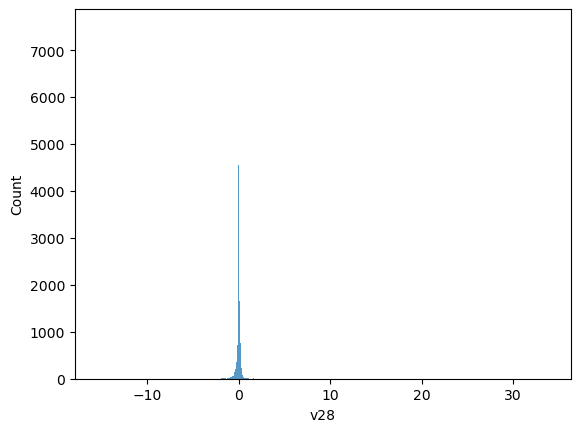

In [17]:
cols_to_exclude = ['time', 'amount', 'class']
for col in df.columns:
    if col not in cols_to_exclude:
        sns.histplot(df[col])
        plt.show()

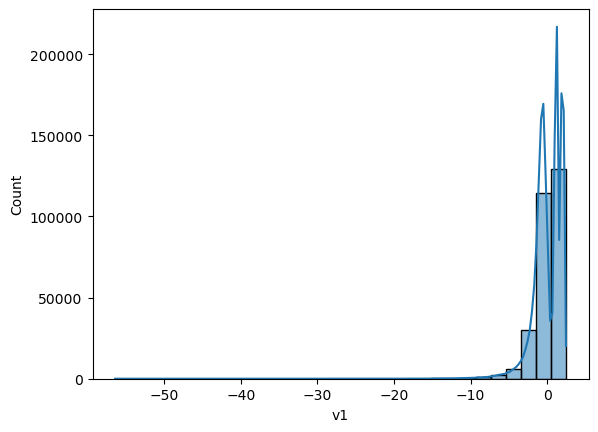

<Figure size 1000x600 with 0 Axes>

In [18]:
sns.histplot(df.v1, bins=30, kde=True)
plt.figure(figsize=(10, 6)) 
plt.show()

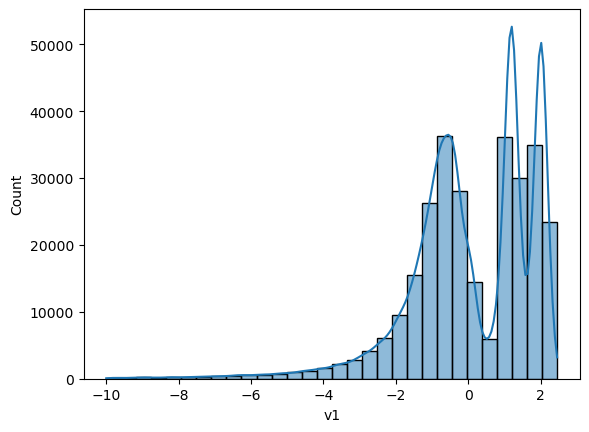

<Figure size 1000x600 with 0 Axes>

In [19]:
sns.histplot(df.v1[df.v1>-10], bins=30, kde=True)
plt.figure(figsize=(10, 6)) 
plt.show()

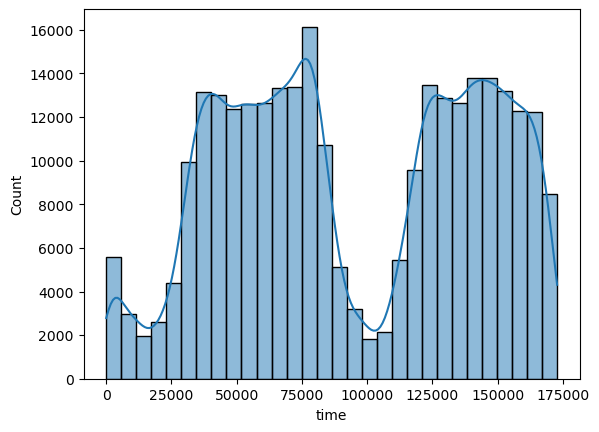

<Figure size 1000x600 with 0 Axes>

In [20]:
sns.histplot(df.time, bins=30, kde=True)
plt.figure(figsize=(10, 6)) 
plt.show()

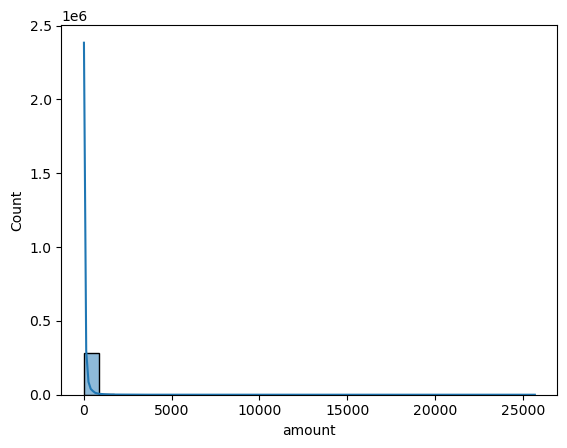

<Figure size 1000x600 with 0 Axes>

In [21]:
sns.histplot(df.amount, bins=30, kde=True)
plt.figure(figsize=(10, 6)) 
plt.show()

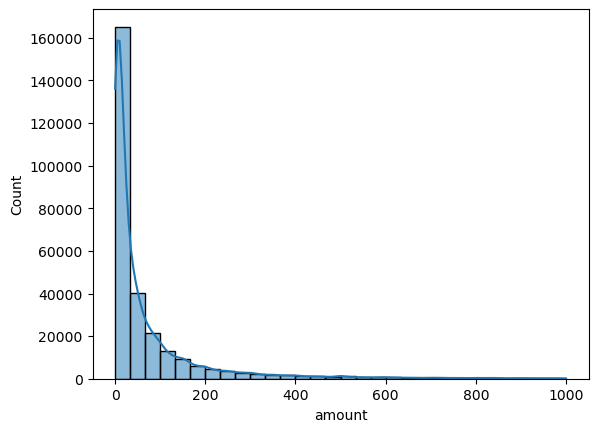

<Figure size 1000x600 with 0 Axes>

In [22]:
sns.histplot(df.amount[df.amount<1000], bins=30, kde=True)
plt.figure(figsize=(10, 6)) 
plt.show()

In [23]:
#there is a long tail in v1 and amount

<Axes: xlabel='v1', ylabel='Count'>

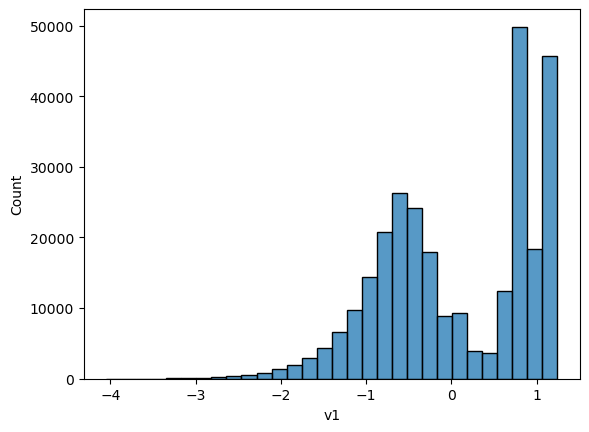

In [24]:
v1_logs =df.v1.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
sns.histplot(v1_logs, bins=30)

<Axes: xlabel='amount', ylabel='Count'>

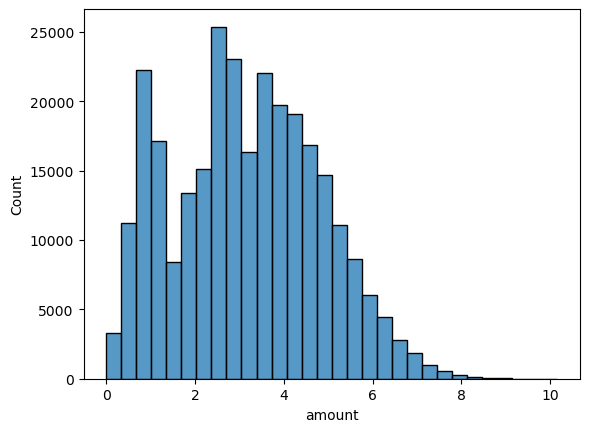

In [25]:
amount_logs =df.amount.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
sns.histplot(amount_logs, bins=30)

In [26]:
#to decide: whether to apply log function to amount and v1

In [27]:
#computing feature importance

In [28]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [29]:
y_train = df_train["class"].values
y_val = df_val["class"].values
y_test = df_test["class"].values

In [30]:
del df_train["class"]
del df_val["class"]
del df_test["class"]

In [31]:
df_full_train.reset_index(drop=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [32]:
def plot_and_get_auc_for_features(df, y, feature_names):
    results_dict = {}
    plt.figure(figsize=(5,5))
    plt.plot ([0,1], [0,1], label = 'Random', linestyle = '--', alpha=0.5)
    for col in feature_names:
        fpr, tpr, thresholds = roc_curve(y_true=y, y_score=df[col])
        auc_score_result = auc(fpr, tpr)
        if (auc_score_result < 0.5):
            fpr, tpr, thresholds = roc_curve(y_true=y, y_score=-df[col])        
            auc_score_result = auc(fpr,tpr)
        plt.plot(fpr,tpr, label =col)        
        results_dict[col]=auc_score_result
    
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

    results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['auc']).reset_index()
    results_df.columns = ['feature', 'auc']  
    return results_df

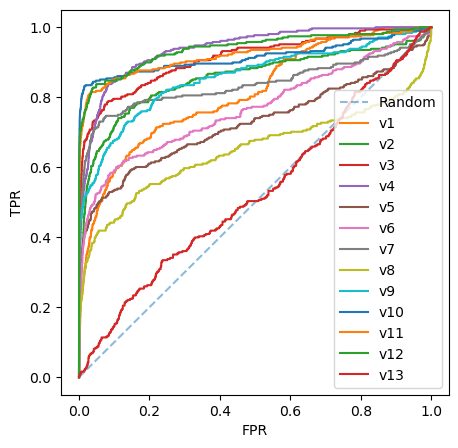

In [33]:
cols_of_interest = [f'v{i}' for i in range(1, 14)]
df_aucs_v1_to_14=plot_and_get_auc_for_features(df_train, y_train, cols_of_interest)

In [34]:
df_aucs_v1_to_14.sort_values(by='auc')

,feature,auc
12,v13,0.524650
7,v8,0.647945
4,v5,0.724869
5,v6,0.765740
0,v1,0.809864
6,v7,0.836140
1,v2,0.854407
8,v9,0.855886
2,v3,0.910838
9,v10,0.915122


In [35]:
#v13 is a low importance feature in the previous subset

In [36]:
#analizing importance of features v15 to v29

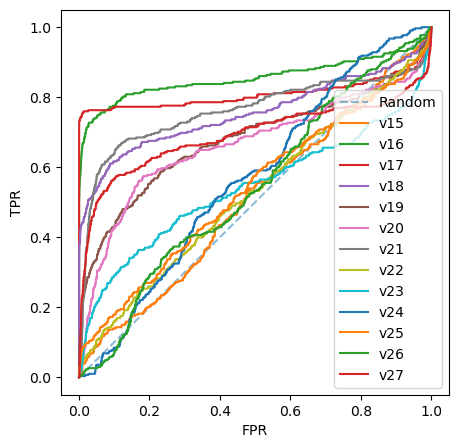

In [37]:
cols_of_interest = [f'v{i}' for i in range(15, 28)]
df_aucs_v15_to_28 = plot_and_get_auc_for_features(df_train, y_train, cols_of_interest)

In [38]:
df_aucs_v15_to_28.sort_values(by='auc', ascending=False)

,feature,auc
1,v16,0.855033
2,v17,0.808995
6,v21,0.760842
3,v18,0.755355
12,v27,0.691242
4,v19,0.677876
5,v20,0.664507
9,v24,0.567130
11,v26,0.540417
8,v23,0.540254


In [39]:
#feature v15 and features v22 to v26 are low imporatance features

In [40]:
#analizing importance of time and amount

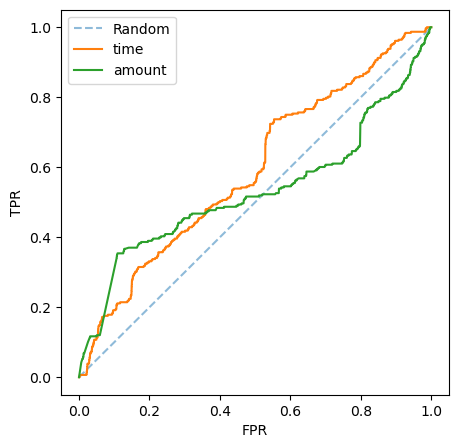

In [41]:
cols_of_interest = ['time','amount']
df_aucs_time_and_amount = plot_and_get_auc_for_features(df_train, y_train, cols_of_interest)

In [42]:
df_aucs_time_and_amount.sort_values(by="auc", ascending=False)

,feature,auc
0,time,0.591360
1,amount,0.530906


In [43]:
#it is significant that amount seems to be a low importante feature

In [44]:
#The low importance features are: v13, v15, v22 to v26, time and amount

In [45]:
#finding the correlation between the features and the target variable

In [46]:
correlation_matrix = df.corr()
correlation_matrix["class"].abs().sort_values(ascending=False)

class     1.000000
v17       0.326481
v14       0.302544
v12       0.260593
v10       0.216883
v16       0.196539
v3        0.192961
v7        0.187257
v11       0.154876
v4        0.133447
v18       0.111485
v1        0.101347
v9        0.097733
v5        0.094974
v2        0.091289
v6        0.043643
v21       0.040413
v19       0.034783
v20       0.020090
v8        0.019875
v27       0.017580
time      0.012323
v28       0.009536
v24       0.007221
amount    0.005632
v13       0.004570
v26       0.004455
v15       0.004223
v25       0.003308
v23       0.002685
v22       0.000805
Name: class, dtype: float64

In [47]:
#This correlation confirms what was observed before regarding the low importance features

In [48]:
#analizing correlation between all the features

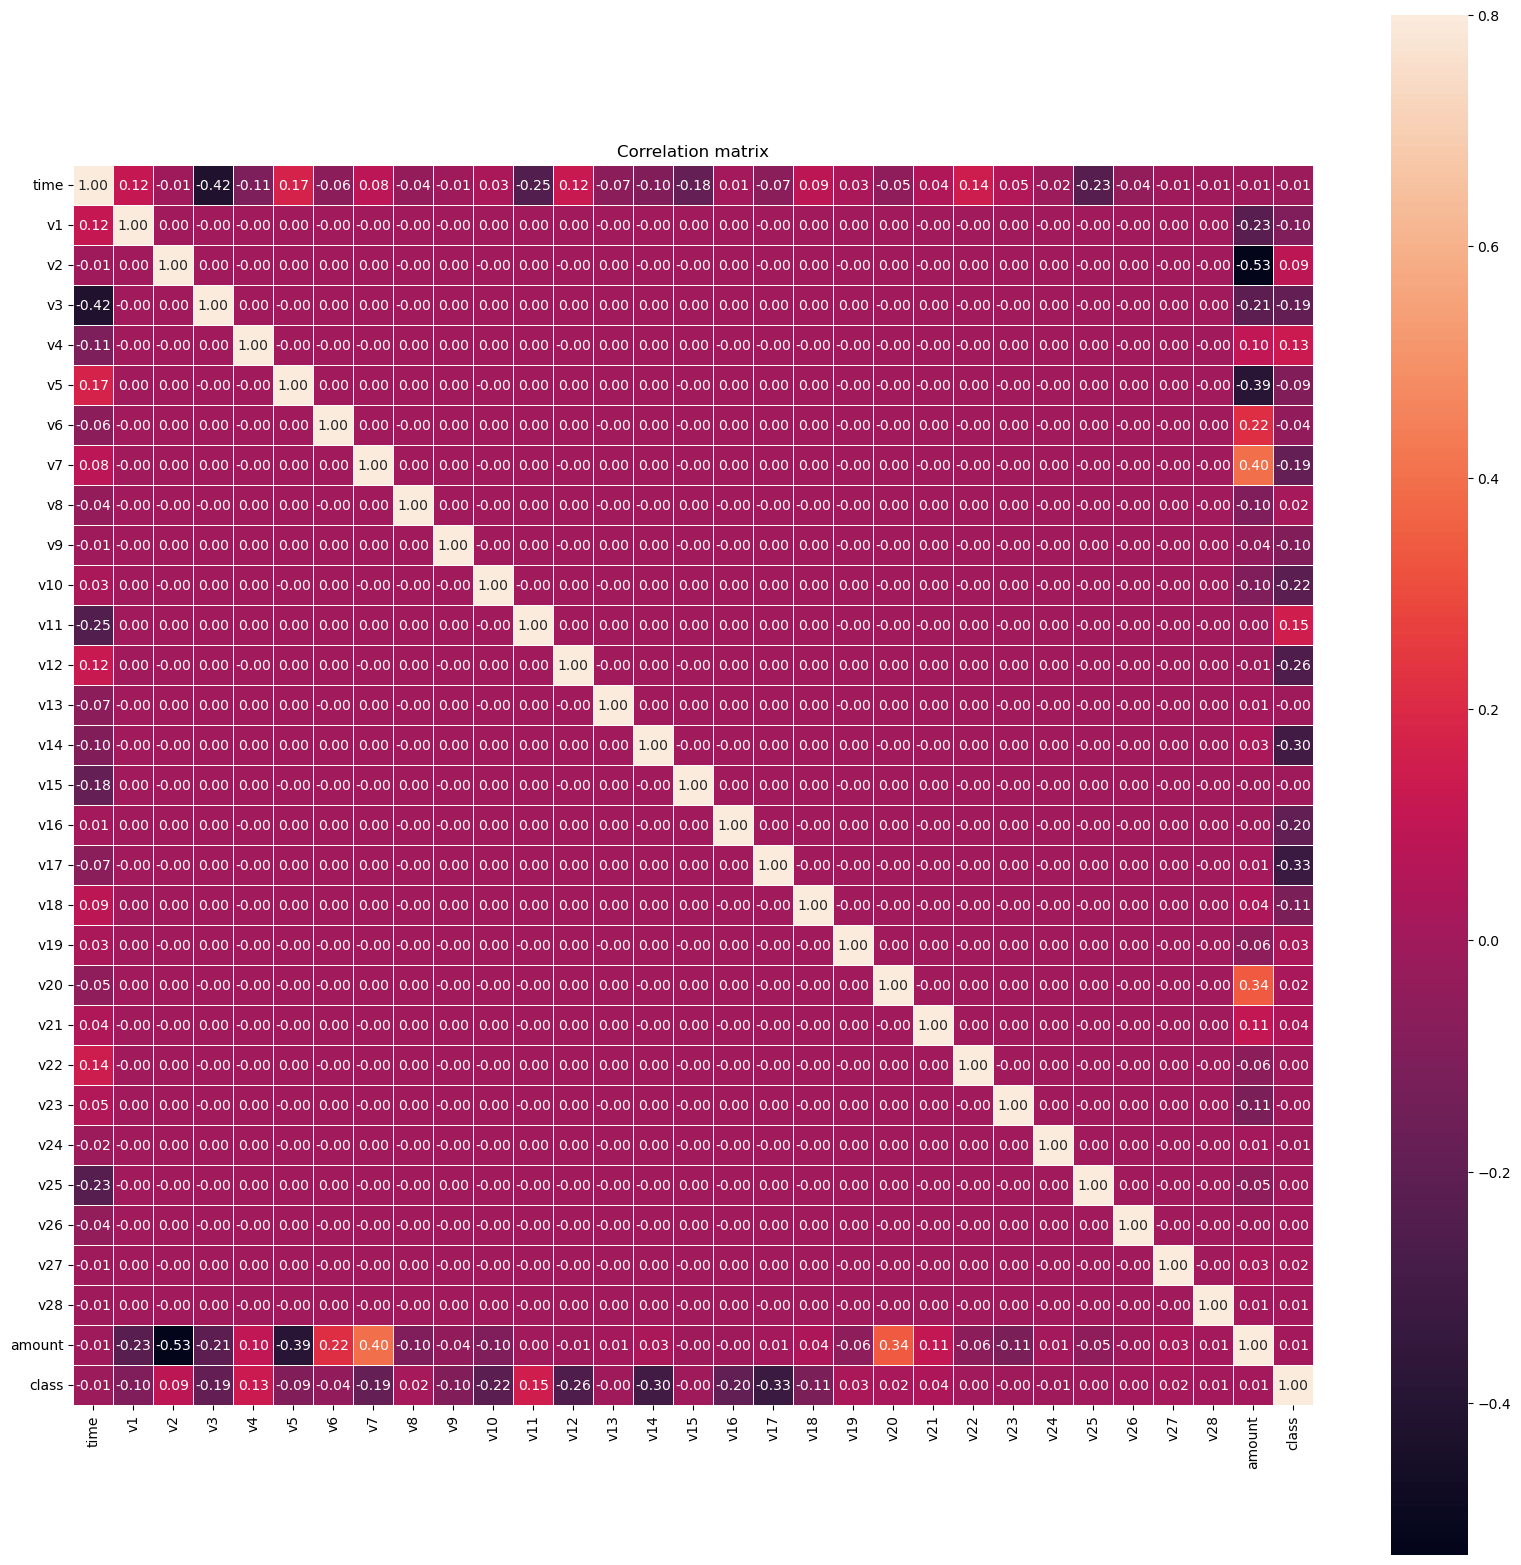

In [49]:
plt.figure(figsize=(20, 20))  
sns.heatmap(correlation_matrix, annot=True, vmax=0.8, fmt=".2f", linewidths=.5, square=True)
plt.title("Correlation matrix")
plt.show()


In [50]:
#the features with the highest correlation are v2 and amount; however, it is still not considered a high correlation

# Training a logistic linear regression

In [51]:
# Training a logistic regression without applying logarithm to amount and v1

In [52]:
def prepare_data(df_train, df_val):
    dv = DictVectorizer(sparse=False)
    
    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val.to_dict(orient='records')    
    X_val = dv.transform(val_dicts)
    
    return X_train, X_val, dv

In [53]:
def evaluate_logistic_regression_auc(df_train, y_train, df_val, y_val):
    X_train, X_val, dv = prepare_data(df_train, df_val)

    model = LogisticRegression(solver="liblinear", max_iter=200, random_state=1)
    model.fit(X_train, y_train)
    
    y_val_pred_proba = model.predict_proba(X_val)[:,1]
    roc_auc = round(roc_auc_score(y_val, y_val_pred_proba),3)
    
    return roc_auc, model, dv, X_train, X_val

In [54]:
roc_auc_without_logs, model, dv, X_train, X_val = evaluate_logistic_regression_auc(df_train, y_train, df_val, y_val)
roc_auc_without_logs

0.949

In [55]:
# Looking at the coefficients

In [56]:
weights = model.coef_[0]
weights_df = pd.DataFrame({'Feature': dv.get_feature_names_out(), 'Weight': weights, 'Abs_Weight': abs(weights)})
weights_df = weights_df.sort_values(by='Abs_Weight', ascending=False)
weights_df

,Feature,Weight,Abs_Weight
23,v3,-0.915685,0.915685
7,v14,-0.737679,0.737679
8,v15,-0.579356,0.579356
19,v25,-0.550691,0.550691
27,v7,0.532026,0.532026
16,v22,0.528441,0.528441
13,v2,-0.503989,0.503989
29,v9,-0.444688,0.444688
28,v8,-0.437031,0.437031
15,v21,0.419575,0.419575


In [57]:
#Here the amount and time has a low weight, which aligns with to the low correlation between these features and the target variable. 
# the low weight for v12 is a surprise, given that it is a high importance feature as per previous analysis


In [58]:
# Evaluating performance of the model when we apply logarithm to amount and v1

In [59]:
df_train_with_logs = df_train
df_train_with_logs.v1 = df_train.v1.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
df_train_with_logs.amount = df_train.amount.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
df_val_with_logs = df_val
df_val_with_logs.v1 = df_val.v1.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
df_val_with_logs.amount = df_val.amount.apply(
    lambda x: -np.log1p(abs(x)) if x < 0 else np.log1p(x)  
)
roc_auc_with_logs, log_model, dv, X_train_with_logs, X_val_with_logs = evaluate_logistic_regression_auc(df_train_with_logs, y_train, df_val_with_logs, y_val)
roc_auc_with_logs

0.927

In [60]:
# There is no improvement in ROC AUC from applying a logarithmic function to the features v1 and amount

In [61]:
# Evaluating the model using other metrics

In [62]:
y_val_pred_proba = model.predict_proba(X_val)[:,1]
y_val_pred = model.predict(X_val)
val_roc_auc= round(roc_auc_score(y_val, y_val_pred_proba),3)
print(f'The ROC AUC for the linear model is {val_roc_auc} on the validation dataset\n')
print(f'Classification Report:\n{classification_report(y_val, y_val_pred)}')

The ROC AUC for the linear model is 0.949 on the validation dataset

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.73      0.62      0.67        97

    accuracy                           1.00     56962
   macro avg       0.87      0.81      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [63]:
y_val_pred_proba_log = log_model.predict_proba(X_val_with_logs)[:,1]
roc_auc_log= round(roc_auc_score(y_val, y_val_pred_proba_log),3)
print (f'The ROC AUC for the lineal model is {roc_auc_log} on the validation dataset given the input is modified with logarithm')
print(f'Classification Report:\n{classification_report(y_val, y_val_pred)}')

The ROC AUC for the lineal model is 0.927 on the validation dataset given the input is modified with logarithm
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.73      0.62      0.67        97

    accuracy                           1.00     56962
   macro avg       0.87      0.81      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [64]:
#Conclusion: There is no improvement from applying a logarithm function to the features v1 and amount

In [65]:
# Parameter tuning 

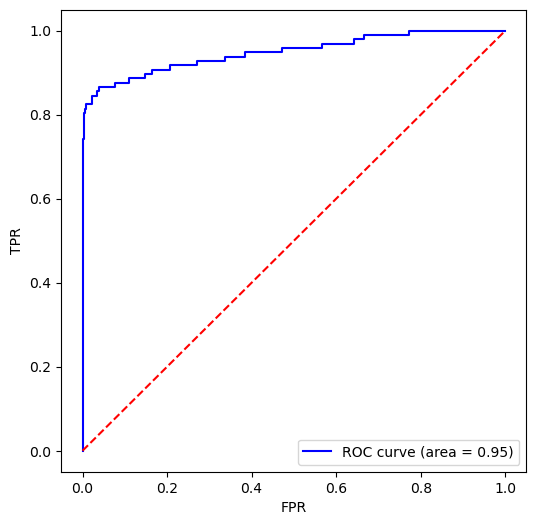

In [66]:
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_val_pred_proba)
roc_auc = round(auc(fpr, tpr),3)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()

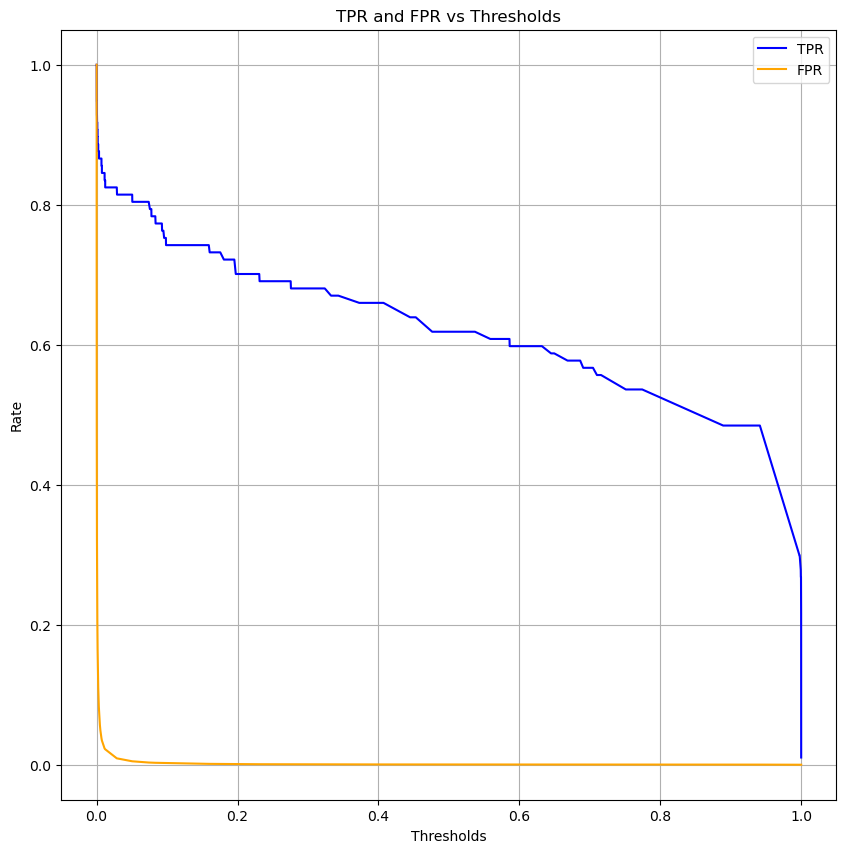

In [67]:
#Plotting FPR and TPR vs thresholds
plt.figure(figsize=(10, 10))
plt.plot(thresholds, tpr, label='TPR', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='orange')
plt.title('TPR and FPR vs Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.grid()
plt.legend()
plt.show()

In [68]:
unique_thresholds = list(set(thresholds))
rounded_thresholds = [round(value, 3) for value in unique_thresholds]

In [69]:
results=[]
for threshold in rounded_thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    results.append((threshold, precision, recall, f1))

# Convertir lista a DataFrame
metrics_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1-score'])
metrics_df.sort_values(by="f1-score", ascending=False, inplace=True)
print(metrics_df)

     threshold  precision    recall  f1-score
178      0.407   0.727273  0.659794  0.691892
176      0.333   0.714286  0.670103  0.691489
177      0.343   0.714286  0.670103  0.691489
63       0.373   0.719101  0.659794  0.688172
33       0.324   0.706522  0.670103  0.687831
..         ...        ...       ...       ...
44       1.000   0.000000  0.000000  0.000000
90       1.000   0.000000  0.000000  0.000000
85       1.000   0.000000  0.000000  0.000000
137        inf   0.000000  0.000000  0.000000
0        1.000   0.000000  0.000000  0.000000

[216 rows x 4 columns]


In [70]:
print(f'A threshold of {metrics_df.iloc[0]["threshold"]} seems to be the best one for this model')

A threshold of 0.407 seems to be the best one for this model


In [71]:
#calculating the roc auc on the validation dataset
y_val_pred_proba = model.predict_proba(X_val)[:,1]
val_roc_auc= round(roc_auc_score(y_val, y_val_pred_proba),3)
print(f'The ROC AUC for the linear model is {val_roc_auc} on the validation dataset.')

The ROC AUC for the linear model is 0.949 on the validation dataset.


In [72]:
#calculating the roc auc on the train dataset
y_train_pred_proba = model.predict_proba(X_train)[:,1]
train_roc_auc= round(roc_auc_score(y_train, y_train_pred_proba),3)
print(f'The ROC AUC for the linear model is {train_roc_auc} on the train dataset.')

The ROC AUC for the linear model is 0.96 on the train dataset.


In [73]:
#store the results in a dictionary
models_auc = {}
models_auc["Logistic Regresion"] = {"val_auc": val_roc_auc,
                                    "train_auc": train_roc_auc}

# Training a decision tree

In [74]:
X_train, X_val, dv = prepare_data(df_train, df_val)

In [75]:
def evaluate_tree_auc (X_train, y_train, X_val, y_val, max_depth=None, min_samples_leaf=1):
    
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)   
    dt.fit(X_train, y_train)
    y_pred_proba = dt.predict_proba(X_val)[:,1]
    score = round(roc_auc_score(y_val, y_pred_proba),3)
    return score, dt

In [76]:
dt_roc_auc, _, = evaluate_tree_auc(X_train, y_train, X_val, y_val)

In [77]:
print (f'The ROC AUC for the decision tree model is: {dt_roc_auc} on the validation dataset')

The ROC AUC for the decision tree model is: 0.876 on the validation dataset


In [78]:
#This model renders a worst AUC than the previous one

In [79]:
#Parameter tuning

In [80]:
depth_results = []
for d in [1,2,3,4,5,6,7,8,9,10, 15, 20]:
    dt_roc_auc, _  = evaluate_tree_auc(X_train, y_train, X_val, y_val, d)
    depth_results.append((d, dt_roc_auc))

In [81]:
depth_results_df = pd.DataFrame(depth_results, columns=['depth', 'auc'])
depth_results_df['depth'] = depth_results_df['depth'].astype(int)
depth_results_df.sort_values(by="auc", ascending=False, inplace=True)
print(depth_results_df)

    depth    auc
2       3  0.902
3       4  0.902
4       5  0.902
10     15  0.895
5       6  0.889
8       9  0.882
1       2  0.881
6       7  0.880
9      10  0.879
11     20  0.876
7       8  0.868
0       1  0.835


In [82]:
depth_list = depth_results_df["depth"].head(5).tolist() 
depth_leaf_results = []
for d in depth_list:
    for s in [1,2, 5, 10, 15, 18, 20]:
        dt_roc_auc, _ = evaluate_tree_auc(X_train, y_train, X_val, y_val, d, s)
        depth_leaf_results.append((d, s, dt_roc_auc))

In [83]:
depth_leaf_df = pd.DataFrame(depth_leaf_results, columns=['depth', 'samples_leaf', 'auc'])
depth_leaf_df.sort_values(by="auc", ascending=False, inplace=True)
print(depth_leaf_df[:15])

    depth  samples_leaf    auc
27     15            20  0.933
26     15            18  0.933
25     15            15  0.933
34      6            20  0.930
33      6            18  0.930
24     15            10  0.927
31      6            10  0.920
30      6             5  0.920
29      6             2  0.920
32      6            15  0.920
22     15             2  0.916
4       3            15  0.912
19      5            18  0.912
18      5            15  0.912
23     15             5  0.912


In [84]:
#there is no big difference in auc between depth=6 and depth=15, so I choose depth=6, min_samples_leaf=18
index = 33
max_depth=int(depth_leaf_df.loc[index]["depth"])
min_samples_leaf=int(depth_leaf_df.loc[index]["samples_leaf"])
dt_val_roc_auc = depth_leaf_df.loc[index]["auc"]
print (f'The best ROC AUC, with a value of {dt_val_roc_auc} can be achieved for a max_depth of '
        f'{max_depth} and a min_samples_leaf of {min_samples_leaf} on the validation dataset')

The best ROC AUC, with a value of 0.93 can be achieved for a max_depth of 6 and a min_samples_leaf of 18 on the validation dataset


In [85]:
#calculating ROC AUC on the train dataset
dt_roc_auc_val, dt = evaluate_tree_auc(X_train, y_train, X_val, y_val, max_depth, min_samples_leaf)
y_pred_proba_train = dt.predict_proba(X_train)[:,1]
dt_train_roc_auc = round(roc_auc_score(y_train, y_pred_proba_train),3)

In [86]:
print(f'The ROC AUC for the decision tree model is {dt_train_roc_auc} on the train dataset')

The ROC AUC for the decision tree model is 0.952 on the train dataset


In [87]:
#store the results in the dictionary
models_auc["Decision Tree"] = {"val_auc": dt_val_roc_auc,
                                "train_auc": dt_train_roc_auc}

# Training a random forest as ensemble model

In [88]:
def evaluate_randomforest_auc(X_train,y_train, X_val, y_val, n_estimators=10):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_val)[:,1]
    return round(roc_auc_score(y_val, y_pred_proba), 3)

In [89]:
rf_roc_auc = evaluate_randomforest_auc(X_train,y_train, X_val, y_val)
print (f'The ROC AUC for the random forest is {rf_roc_auc} on the validation dataset')

The ROC AUC for the random forest is 0.922 on the validation dataset


In [90]:
# Parameter tuning

In [91]:
results = []
for n in range (10, 150, 10):
    roc_auc = evaluate_randomforest_auc(X_train,y_train, X_val, y_val, n_estimators=n)
    results.append((n, roc_auc))

In [92]:
n_estimators_results_df = pd.DataFrame(results, columns=['n_estimators', 'auc'])
n_estimators_results_df.sort_values(by=["auc", "n_estimators"], ascending=[False, True], inplace=True)
print(n_estimators_results_df)

    n_estimators    auc
9            100  0.952
10           110  0.952
11           120  0.952
12           130  0.952
13           140  0.952
7             80  0.947
8             90  0.947
3             40  0.942
4             50  0.942
5             60  0.942
6             70  0.942
2             30  0.937
1             20  0.933
0             10  0.922


In [93]:
rf_val_roc_auc = n_estimators_results_df.iloc[0]["auc"]
n_estimators = int(n_estimators_results_df.iloc[0]["n_estimators"])
print(f'The ROC AUC for the random forest is {rf_val_roc_auc} on the validation dataset'
      f' using {n_estimators} estimators')

The ROC AUC for the random forest is 0.952 on the validation dataset using 100 estimators


In [94]:
#evaluating the model on the train dataset
rf_train_roc_auc = evaluate_randomforest_auc(X_train,y_train, X_train, y_train, n_estimators)

In [95]:
print(f'The ROC AUC for the random forest is {rf_train_roc_auc} on the train dataset'
      f' using {n_estimators} estimators')

The ROC AUC for the random forest is 1.0 on the train dataset using 100 estimators


In [96]:
#Conclusion: The random forest isn't a better model than the decision tree and might be overfitting

In [97]:
#store the results in the dictionary
models_auc["Random Forest"] = {"val_auc": rf_val_roc_auc,
                                "train_auc": rf_train_roc_auc}

# Gradient boosting as ensemble model

In [98]:
def prepare_matrix(df, y):
    dv = DictVectorizer(sparse=False)
    dicts = df.to_dict(orient='records')
    X = dv.fit_transform(dicts)
    features = list(dv.get_feature_names_out())
    dtrain = xgb.DMatrix(X, label=y, feature_names=features)
    return dtrain, dv

In [99]:
def train (df_train, y_train, xgb_params, num_boost_round):
    dMatrix, dv = prepare_matrix(df_train, y_train)
    model_xgb=xgb.train(xgb_params, dMatrix, num_boost_round=num_boost_round)
    return model_xgb, dv

In [100]:
def predict (df, dv, model):
    dicts = df.to_dict(orient='records')
    X=dv.transform(dicts)
    features = list(dv.get_feature_names_out())
    dMatrix = xgb.DMatrix(X, feature_names=features)
    y_pred_proba = model.predict(dMatrix)

    return y_pred_proba

In [101]:
xgb_params ={
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1
}
model_xgb, dv =train(df_train, y_train, xgb_params, 200)

In [102]:
y_val_pred_proba = predict(df_val, dv, model_xgb)

In [103]:
round(roc_auc_score(y_val, y_val_pred_proba),3)

0.971

In [104]:
#Parameter tunning

In [105]:
print('Tuning parameters for the Gradient Boosting model')

Tuning parameters for the Gradient Boosting model


In [106]:
eta_values = [0.1, 0.3, 0.5] 
max_depth_values = [1, 3, 6, 10, 15, 20]
min_child_weight_values = [1, 5, 10, 15, 20]  
num_boost_round_values = [50, 100, 150] 
results_xgb = []
for eta, max_depth, min_child_weight, num_boost_round in itertools.product(
        eta_values, max_depth_values, min_child_weight_values, num_boost_round_values):
    
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'objective': 'binary:logistic',
        'seed': 1,
        'verbosity': 1
    }

    model_xgb, dv =train(df_train, y_train, xgb_params, num_boost_round)
    y_val_pred_proba = predict(df_val, dv, model_xgb)
    auc_score = round(roc_auc_score(y_val, y_val_pred_proba),3)
    
    results_xgb.append((eta, max_depth, min_child_weight, num_boost_round, auc_score))
    

In [107]:
results_df = pd.DataFrame(results_xgb, columns=['eta', 'max_depth', 'min_child_weight', 'num_boost_round', 'auc'])
best_result = results_df.loc[results_df['auc'].idxmax()]
results_df_filtered = results_df[results_df["auc"] == best_result["auc"]]
results_df_filtered.sort_values(by="num_boost_round")
xg_val_roc_auc = best_result["auc"]
print(results_df_filtered)

     eta  max_depth  min_child_weight  num_boost_round    auc
106  0.3          3                 1              100  0.985
205  0.5          3                15              100  0.985


In [108]:
#selecting the parameters to train the model
best_eta = 0.3
best_max_depth = 3
best_min_child_weight = 1
best_num_boost_round = 100
print(f'The ROC AUC of the Gradient Boosting is {xg_val_roc_auc} on the validation dataset with the following parameters:\n'
           f' - Learning Rate (eta): {best_eta}\n'
           f' - Max Depth: {best_max_depth}\n'
           f' - Min Child Weight: {best_min_child_weight}\n'
           f' - Number of Trees (num_boost_round): {best_num_boost_round}')

The ROC AUC of the Gradient Boosting is 0.985 on the validation dataset with the following parameters:
 - Learning Rate (eta): 0.3
 - Max Depth: 3
 - Min Child Weight: 1
 - Number of Trees (num_boost_round): 100


In [109]:
#evaluating auc on the train dataset
xgb_params = {
    'eta': best_eta,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1
}

model_xgb, dv =train(df_train, y_train, xgb_params, best_num_boost_round)
y_val_pred_proba = predict(df_val, dv, model_xgb)

In [110]:
xg_train_roc_auc = round(roc_auc_score(y_val, y_val_pred_proba),3)
xg_train_roc_auc

0.985

In [111]:
print(f'The ROC AUC of the Gradient Boosting is {xg_train_roc_auc} on the train dataset')

The ROC AUC of the Gradient Boosting is 0.985 on the train dataset


In [112]:
#store the results in the dictionary
models_auc["Gradient Boosting"] = {"val_auc": xg_val_roc_auc,
                                   "train_auc": xg_train_roc_auc}

In [113]:
#finding the best threshold
thresholds = np.arange(0.0, 1.1, 0.01)
results = []

for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    results.append((threshold, precision, recall, f1))


In [114]:
metrics_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1-score'])
metrics_df.sort_values(by=['precision','f1-score', 'threshold'], ascending=[False, False, False], inplace=True)

In [115]:
#Objective: have a high precision, without missclasifying more than 20% of fraudulent transactions
metrics_filtered = metrics_df[metrics_df["recall"]>0.80]
metrics_sorted =metrics_filtered.sort_values(by=["recall", "precision", "f1-score", "threshold"], 
                             ascending=[False, False, False, False])                   
print ('Metrics:\n')
print(metrics_filtered[:30])

Metrics:

    threshold  precision    recall  f1-score
72       0.72   0.987500  0.814433  0.892655
71       0.71   0.987500  0.814433  0.892655
70       0.70   0.987500  0.814433  0.892655
75       0.75   0.987342  0.804124  0.886364
74       0.74   0.987342  0.804124  0.886364
73       0.73   0.987342  0.804124  0.886364
68       0.68   0.975610  0.824742  0.893855
67       0.67   0.975610  0.824742  0.893855
66       0.66   0.975610  0.824742  0.893855
69       0.69   0.975309  0.814433  0.887640
55       0.55   0.964286  0.835052  0.895028
54       0.54   0.964286  0.835052  0.895028
65       0.65   0.963855  0.824742  0.888889
64       0.64   0.963855  0.824742  0.888889
63       0.63   0.963855  0.824742  0.888889
62       0.62   0.963855  0.824742  0.888889
61       0.61   0.963855  0.824742  0.888889
60       0.60   0.963855  0.824742  0.888889
59       0.59   0.963855  0.824742  0.888889
58       0.58   0.963855  0.824742  0.888889
57       0.57   0.963855  0.824742  0.888889


In [116]:
#Conclusion: there is a better precision by using a threshold of 0.70 than using 0.5

# Displaying results for all models

In [117]:
models_auc_df = pd.DataFrame.from_dict(models_auc, orient="index")
models_auc_df.reset_index(inplace=True)
models_auc_df.rename(columns={"index":"model"}, inplace=True)
models_auc_df.sort_values(by="val_auc", ascending=False, inplace=True)
print(models_auc_df)

                model  val_auc  train_auc
3   Gradient Boosting    0.985      0.985
2       Random Forest    0.952      1.000
0  Logistic Regresion    0.949      0.960
1       Decision Tree    0.930      0.952


In [118]:
#the best model is Gradient Boosting and is the one that will be used

# Cross-Validation on the Final Model

In [119]:
print('Executing cross validation for the final model')

Executing cross validation for the final model


In [120]:
xgb_params = {
    'eta': best_eta,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1
}
n_splits = 5
results_fold = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1) 
for train_idx, val_idx in  kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train["class"].values
    y_val = df_val["class"].values

    del df_train["class"]
    del df_val["class"]

    model, dv =train(df_train, y_train, xgb_params, best_num_boost_round)
    y_pred_proba = predict(df_val, dv, model)   

    auc = roc_auc_score(y_val, y_pred_proba)
    results_fold.append(auc)

In [121]:
print(f'AUC for each fold: {results_fold}')

AUC for each fold: [0.9789510586134168, 0.9812505975910242, 0.9847482924911055, 0.9784867433777108, 0.9881694957605148]


In [122]:
mean_auc = np.mean(results_fold)
print(f'Mean AUC: {mean_auc:.3f}')

Mean AUC: 0.982


In [123]:
std_auc = np.std(results_fold)
print(f'Standard Deviation of AUC: {std_auc:.3f}')

Standard Deviation of AUC: 0.004


In [124]:
print(f'Best AUC: {max(results_fold):.3f}')
print(f'Worst AUC: {min(results_fold):.3f}')

Best AUC: 0.988
Worst AUC: 0.978


# Training the final model with the entire training dataset

In [125]:
df_full_train=df_full_train.reset_index(drop=True)

In [126]:
y_full_train = df_full_train["class"].values

In [127]:
del df_full_train["class"]

In [128]:
xgb_params = {
    'eta': best_eta,
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1
}
model, dv =train(df_full_train, y_full_train, xgb_params, best_num_boost_round)
y_pred_proba = predict(df_test, dv, model)    

In [129]:
round(roc_auc_score(y_test, y_pred_proba),3)

0.965

In [130]:
#Conclusion: the XGBoost generalized well for unknown data and it has better performance than other models